In [1]:
%matplotlib inline
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from transformers import AutoModelForQuestionAnswering, AutoModelForSequenceClassification
from transformers import BertForSequenceClassification, BertForPreTraining
from transformers import AdamW
#from transformers import BertForFeatureExtraction
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer
import numpy as np
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import generalized_rcnn
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate, evaluate_iou
import utils
import transforms as T

from PIL import Image, ImageDraw
from utils_ref.refvg_loader import RefVGLoader
import cv2
import json
from matplotlib import pyplot as plt
import os

from collections import OrderedDict
import torch
from torch import nn
import warnings
from torch.jit.annotations import Tuple, List, Dict, Optional
from torch import Tensor


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# refvg_loader = RefVGLoader(split='miniv')
# img_ref_data = refvg_loader.get_img_ref_data()

# for task_i, task_id in enumerate(img_ref_data['task_ids']):
#     phrase = img_ref_data['phrases'][task_i]
#     gt_boxes = img_ref_data['gt_boxes'][task_i]
#     gt_Polygons = img_ref_data['gt_Polygons'][task_i]
#     print(gt_Polygons)
#     print("...................")
def collate_fn(batch):
    return tuple(zip(*batch))

countertop


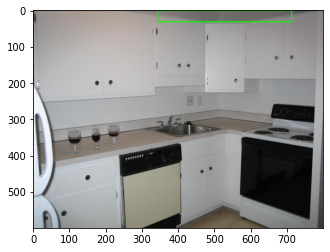

In [4]:
train_path = 'data/VGPhraseCut_v0/refer_train.json'
test_path = 'data/VGPhraseCut_v0/refer_test.json'
img_path = 'data/VGPhraseCut_v0/images/'
img_size = 320
with open(train_path) as f:
    data = json.load(f)

# for d in data:
#     for key,value in d.items():
#         print(key,value)
        
sample = data[120]
#print(sample)
img = cv2.imread(img_path+str(sample["image_id"])+".jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(sample["phrase"])
bboxes = sample["instance_boxes"]
for bbox in bboxes:
    bbox = [int(x) for x in bbox]
    cv2.rectangle(img,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[1]+bbox[3]),(0,255,0),2)

plt.imshow(img)
##print(img.shape)


In [5]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    #if train:
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
class ImageDataset(object):
    def __init__(self, refer_path, root, tokenizer, transforms=None,is_ins=False):
        self.root = root
        self.transforms = transforms
        self.is_ins = is_ins
        self.refer_path = refer_path
        # load all image files, sorting them to
        # ensure that they are aligned
        #self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        #self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
        with open(self.refer_path) as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        # load images ad masks
        #img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        sample = self.data[idx]
        img_path = self.root + str(sample["image_id"]) + ".jpg"
        #mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        
        img = cv2.imread(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        shape = img.shape
        
        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size,img_size))
        #img = cv2.resize(img,dsize=(img_size,img_size))
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        #mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        #mask = np.array(mask)
        # instances are encoded as different colors
        #obj_ids = np.unique(mask)
        # first id is the background, so remove it
        #obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        #masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        #num_objs = len(obj_ids)
        bboxes = sample["instance_boxes"]
        num_objs = len(bboxes)
        boxes = []
#         for i in range(num_objs):
#             pos = np.where(masks[i])
#             xmin = np.min(pos[1])
#             xmax = np.max(pos[1])
#             ymin = np.min(pos[0])
#             ymax = np.max(pos[0])
#             boxes.append([xmin, ymin, xmax, ymax])
        for bbox in bboxes:
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[0] + bbox[2]
            ymax = bbox[1] + bbox[3]
            
            xmin = xmin/shape[1]*img_size
            ymin = ymin/shape[0]*img_size
            xmax = xmax/shape[1]*img_size
            ymax = ymax/shape[0]*img_size
            
            boxes.append([xmin, ymin, xmax, ymax])
            

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        encoding = tokenizer(sample["phrase"], return_tensors='pt', padding="max_length", truncation=True,max_length=5)
        

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #target["ins"] = encoding['input_ids']
        if self.is_ins:
            target["orig_ins"] = sample["phrase"]
        target["attention_mask"] = encoding['attention_mask'][0]

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, encoding['input_ids'][0], target

    def __len__(self):
        return len(self.data)

In [7]:
  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  
lang_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [8]:
# train_dataset = ImageDataset(train_path,img_path,tokenizer,is_ins=True)
# test_dataset = ImageDataset(test_path,img_path,tokenizer,is_ins=True)
# img,ins, target = train_dataset[10]
# boxes = target["boxes"].numpy()

# for box in boxes:
#     box = [int(x) for x in box]
#     cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)
    
# print(ins)
# plt.imshow(img)

NameError: name 'ins' is not defined

In [9]:
#vision_model = maskrcnn_resnet50_fpn(pretrained=True)

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_model_rcnn(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    #num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

vision_model = get_model_rcnn(2)

In [10]:
train_dataset = ImageDataset(train_path,img_path,tokenizer,get_transform(train=True))
test_dataset = ImageDataset(test_path,img_path,tokenizer,get_transform(train=False))
#train_dataset = ImageDataset(img_path,tokenizer)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4,collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4,collate_fn=collate_fn)


images,ins,targets = next(iter(train_loader))
images = list(images)
ins = list(ins)
ins = torch.stack(ins,dim=0)
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
vision_model.eval()
output = vision_model(images)   # Returns losses and detections
print(output[0]['scores'].shape)
output = lang_model(ins)
# For inference
vision_model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = vision_model(x)           # Returns predictions
print(predictions)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


torch.Size([100])
[{'boxes': tensor([[  0.0000,   0.0000, 345.0599, 261.1065],
        [ 24.4568,   0.0000, 390.6284, 122.4222],
        [ 60.9846,   0.0000, 223.9870, 295.7891],
        [ 76.0443,  97.0241, 263.9994, 255.9503],
        [340.7351,  77.7630, 344.9230,  81.5418],
        [342.3956,  77.6096, 345.6549,  82.0931],
        [163.2964, 109.1157, 356.2625, 280.6500],
        [160.3802, 121.3020, 164.2033, 125.5647],
        [  3.6590,   0.5190, 154.8071, 278.8182],
        [340.2065,  79.0281, 343.6133,  82.9442],
        [293.8069,  75.6420, 297.6172,  79.8803],
        [161.8028, 121.1392, 165.4378, 125.4659],
        [101.6320, 130.0708, 107.7969, 134.2762],
        [293.7512,  70.7240, 297.6400,  74.8955],
        [127.3271,  90.5887, 130.8441,  94.3878],
        [159.0395, 120.9695, 163.1538, 124.5513],
        [160.3186, 123.1927, 164.3004, 126.6800],
        [124.3955,  37.6973, 312.0191, 204.5734],
        [341.9453,  79.6007, 345.4135,  83.5395],
        [262.1741,  7

In [11]:
class MultiModal(GeneralizedRCNN):
    def __init__(self,vision_model,lang_model):
        

        backbone = vision_model.backbone
        rpn = vision_model.rpn
        transform = vision_model.transform
        roi_heads = vision_model.roi_heads
        #self.vision_model = vision_model
        super(MultiModal, self).__init__(backbone, rpn, roi_heads, transform)
        self.vision_model = vision_model
        self.lang_model = lang_model
        self.linear0 = nn.Linear(768, 256)
        self.linear1 = nn.Linear(768, 256)
        self.linear2 = nn.Linear(768, 256)
        self.linear3 = nn.Linear(768, 256)
#         self.linear0 = nn.Linear(768, 256*25*25)
        #self.linear0 = nn.Linear(768, 256)
#         self.mult0 = nn.Conv1d(10,4,1)
#     def forward(self, img,ins):
#         X_img = self.vision_model.backbone(img)
#         #print(ins.shape)
#         #print(img.shape)
#         X_ins = self.lang_model.bert(ins)
#         #print(X_img.shape)
#         #print(X_ins.shape)
#         print(X_img['3'].shape)
#         return X_img

    def forward(self, images, ins,targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError("Expected target boxes to be a tensor"
                                         "of shape [N, 4], got {:}.".format(
                                             boxes.shape))
                else:
                    raise ValueError("Expected target boxes to be of type "
                                     "Tensor, got {:}.".format(type(boxes)))

        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenrate box
                    bb_idx = degenerate_boxes.any(dim=1).nonzero().view(-1)[0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError("All bounding boxes should have positive height and width."
                                     " Found invaid box {} for target at index {}."
                                     .format(degen_bb, target_idx))
        ins = torch.stack(ins,dim=0)
        X_ins = self.lang_model.bert(ins)
        #X_ins = self.mult0(X_ins)
        X_ins = X_ins[0]

        X_ins0 = X_ins[:,0,:]
        X_ins1 = X_ins[:,1,:]
        X_ins2 = X_ins[:,2,:]
        X_ins3 = X_ins[:,3,:]

        X_ins0 = F.relu(self.linear0(X_ins0))
        X_ins1 = F.relu(self.linear1(X_ins1))
        X_ins2 = F.relu(self.linear2(X_ins2))
        X_ins3 = F.relu(self.linear3(X_ins3))
        
        X_ins0 = X_ins0.reshape(-1,256,1,1)
        X_ins1 = X_ins1.reshape(-1,256,1,1)
        X_ins2 = X_ins2.reshape(-1,256,1,1)
        X_ins3 = X_ins3.reshape(-1,256,1,1)
#         X_ins0 = X_ins0.reshape(-1,256,25,25)
        
        features = self.backbone(images.tensors)
#         print(features['0'].shape)
#         print(features['1'].shape)
#         print(features['2'].shape)
#         print(features['3'].shape)
        
        features['0'] = F.relu(X_ins0*features['0'])
        features['1'] = F.relu(X_ins1*features['1'])
        features['2'] = F.relu(X_ins2*features['2'])
        features['3'] = F.relu(X_ins3*features['3'])
#         features['3'] = X_ins0
        
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])
#         print(features['0'].shape)
#         print(features['1'].shape)
#         print(features['2'].shape)
#         print(features['3'].shape)
        proposals, proposal_losses = self.rpn(images, features, targets)
        #print(proposal_losses)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        
        #print("Detections: ",detections)
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return (losses, detections)
        else:
            return self.eager_outputs(losses, detections)
        

In [12]:
print("Language Model")
#print(lang_model)
print("Vision Model")


net = MultiModal(vision_model,lang_model)
print(net)
#vision_model.eval()
net.train()
# images,ins,targets = next(iter(data_loader))
# images = list(images)
# targets = list(targets)
# images = torch.stack(images,dim=0)
# ins = list(ins)
# ins = torch.stack(ins,dim=0)
# print(images.shape)
# print(targets)
# #x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = net(images,ins,targets) 
# print(predictions)

Language Model
Vision Model
MultiModal(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
   

MultiModal(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [ ]:
net = net.to(device)
params = [p for p in net.parameters() if p.requires_grad]
# for p in lang_model.parameters():
#     print(p.name)
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
#params_lang = sum([np.prod(p.size()) for p in model_parameters])
#print(params_lang)
#for param in params:
#    print(param.name)
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    
    train_one_epoch(net, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    evaluate_iou(net, test_loader, device=device)
    # evaluate on the test dataset
    #evaluate(net, data_loader, device=device)

Epoch: [0]  [    0/19426]  eta: 5 days, 23:23:49  lr: 0.000010  loss: 0.1463 (0.1463)  loss_classifier: 0.0670 (0.0670)  loss_box_reg: 0.0346 (0.0346)  loss_objectness: 0.0272 (0.0272)  loss_rpn_box_reg: 0.0174 (0.0174)  time: 26.5742  data: 2.5602  max mem: 24438
Epoch: [0]  [   10/19426]  eta: 1 day, 1:22:22  lr: 0.000060  loss: 0.1639 (0.1675)  loss_classifier: 0.0831 (0.0863)  loss_box_reg: 0.0464 (0.0431)  loss_objectness: 0.0209 (0.0217)  loss_rpn_box_reg: 0.0128 (0.0163)  time: 4.7045  data: 0.2657  max mem: 25012
Epoch: [0]  [   20/19426]  eta: 16:24:50  lr: 0.000110  loss: 0.1639 (0.1621)  loss_classifier: 0.0808 (0.0844)  loss_box_reg: 0.0443 (0.0435)  loss_objectness: 0.0188 (0.0202)  loss_rpn_box_reg: 0.0099 (0.0140)  time: 1.8685  data: 0.0398  max mem: 25012
Epoch: [0]  [   30/19426]  eta: 13:22:12  lr: 0.000160  loss: 0.1582 (0.1640)  loss_classifier: 0.0793 (0.0824)  loss_box_reg: 0.0406 (0.0427)  loss_objectness: 0.0189 (0.0240)  loss_rpn_box_reg: 0.0114 (0.0149)  time

In [14]:
evaluate_iou(net, test_loader, device=device)

creating index...
index created!


100%|██████████| 898/898 [08:22<00:00,  1.79it/s]

Accuracy:  36.707537968510515


In [ ]:
import torch.nn.functional as F
A = torch.randn(2, 4, 8, 8)
#M = torch.randn(2, 4,4,4)
print(A[0])
#M = M.reshape(-1,4,1,1)

M = torch.randn(2,4)
print(M[0])
M = M.reshape(-1,4,1,1)
# cn = nn.Conv2d(4,4,kernel_size=1,groups=4)
# print(cn.parameters())
# output = F.conv2d(A, M,padding=0,groups=4)
# print(output.shape)
out = M*A
print(out[0])
print(out.shape)

In [ ]:
-0.4487*0.9124